# 1 - Simple regression model in TensorFlow 2.0

In this notebook, we'll take a look at using TensorFlow 2.0 and the `tf.keras` interface to execute on a simple regression problem. We'll also take a look at the repeatability of machine learning training techniques and see if any uncertainty exists, and this example model isn't telling us about it.

Much of the material in this notebook is adapted from the TensorFlow 2.0 intro tutorial, available here: https://www.tensorflow.org/tutorials/keras/regression.

Let's get some data from the cars data set!

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.get_logger().setLevel('ERROR')

print(tf.__version__)

2.0.0


In [2]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/zach_anglin/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Now that we have some data, we need to go about cleaning it.

In [4]:
# Drop NA values
dataset = dataset.dropna()

In [5]:
# We need to turn origin into a one-hot encoded vector.

origin = dataset.pop('Origin')

In [6]:
dataset['USA'] = (origin == 1) * 1.0  # Cast Series to float
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Split the data set into an 80/20 train/test division.

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Explore data

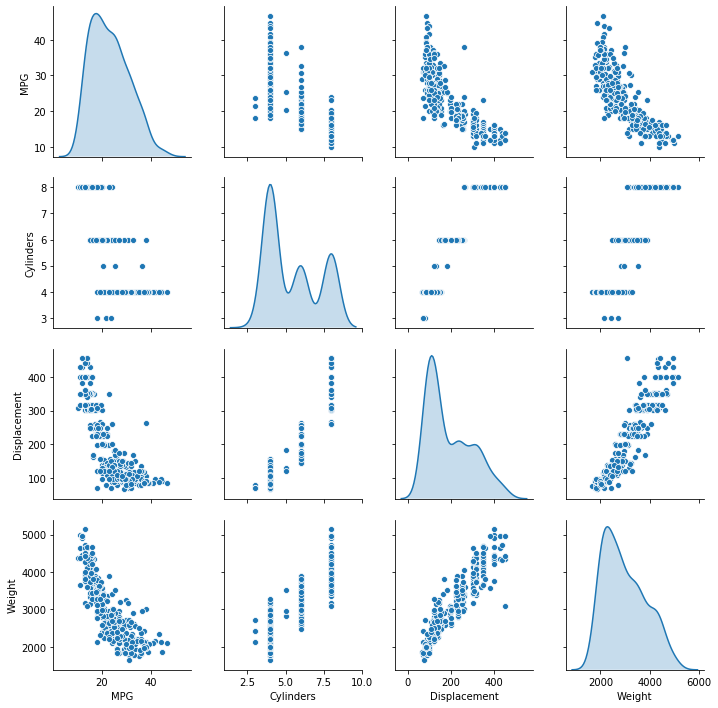

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG") 
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Now let's normal-transform our training and test data sets for use in a regression network.

## Why do we need to do this normal transform?

There are broadly two reasons that a normalizing transformation is good practice before training a neural network. First, it ensures that all input features are commensurate with one another and treated equally -- variance in one feature due to units doesn't exact an undue influence over the entire model. Second, it enforces that the network is receiving both positive and negative inputs, which (depending on your activation function) might have an impact on the model's training performance.

For more detail on this topic, I recommend the following blog post from Timo Stöttner:

In [14]:
%%HTML
<iframe src="https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d" width="900" height="500"></iframe>

In [11]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
def build_model() -> tf.keras.Model:
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [13]:
model = build_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


4,865 parameters -- how many observations do we have, anyway?

In [15]:
normed_train_data.shape

(314, 9)

Pass an example batch through the model.

In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.12717636],
       [0.23551516],
       [0.42345396],
       [0.2064361 ],
       [0.30734527],
       [0.21771821],
       [0.27875608],
       [0.03437432],
       [0.21414956],
       [0.11211875]], dtype=float32)

And again, just for good measure.

In [17]:
model.predict(example_batch)

array([[0.12717636],
       [0.23551516],
       [0.42345396],
       [0.2064361 ],
       [0.30734527],
       [0.21771821],
       [0.27875608],
       [0.03437432],
       [0.21414956],
       [0.11211875]], dtype=float32)

Note that we got the **same** predictions when passing the same training records through the graph.

What will happen if we train a _new_ model and predict on these same records?

In [18]:
model2 = build_model()

model2.predict(example_batch)

array([[-0.2932623 ],
       [-0.07601981],
       [-0.38309133],
       [-0.2754855 ],
       [-0.17604262],
       [-0.02785384],
       [-0.17826444],
       [-0.0513538 ],
       [-0.02715447],
       [-0.0671993 ]], dtype=float32)

Different results. That's due to _random initialization of the network weights_. But, of course, these networks are untrained, so no real concern.

## Train the network

We'll use a `keras` _callback_ to print a dot at the end of every epoch, just to give us a sense of how quickly things are progressing. We'll train for 1,000 epochs using an 80/20 _training/validation_ split.

In [19]:
class PrintDot(keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for 
    each completed epoch.
    """
    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoc_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

        
EPOCHS = 1000


history = model.fit(
    normed_train_data, 
    train_labels,
    epochs=EPOCHS, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Because we've outputted the training results to the `history` variable, we can access the results of each epoch natively.

In [20]:
history

What methods are available on this object?

In [21]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_keras_api_names',
 '_keras_api_names_v1',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

Here, we'll use the `history.history` dictionary accessor and cast it to a `pandas` `DataFrame`.

In [22]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,558.313916,22.292562,558.313904,551.682411,22.039917,551.682434
1,509.329371,21.103104,509.329407,501.714747,20.801769,501.714752
2,460.376780,19.866629,460.376770,445.857694,19.382477,445.857697
3,406.390395,18.470711,406.390411,385.455736,17.754887,385.455719
4,348.474478,16.855032,348.474518,320.984907,15.973777,320.984894


So, that gives us the loss, mean absolute error, and mean squared error from both the training and validation sets, indexed by epoch. To make this explicit, let's tack on the epoch indices as a column themselves.

In [23]:
hist_df['epoch'] = history.epoch
hist_df.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.428237,1.019923,2.428237,7.194723,2.053447,7.194724,995
996,2.428793,1.048187,2.428793,7.258256,2.113956,7.258256,996
997,2.381019,0.994397,2.381019,7.278555,2.090306,7.278555,997
998,2.379971,1.019035,2.379970,7.139082,2.036724,7.139082,998
999,2.411838,1.008455,2.411838,7.058106,2.054368,7.058106,999


Seeing as we've got both the training and validation stats by epoch, it makes natural sense to plot them and see how they evolve as the network trains.

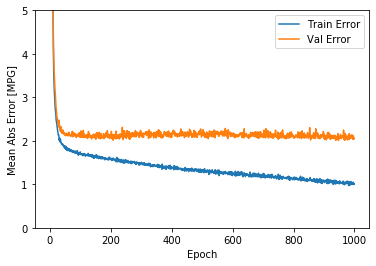

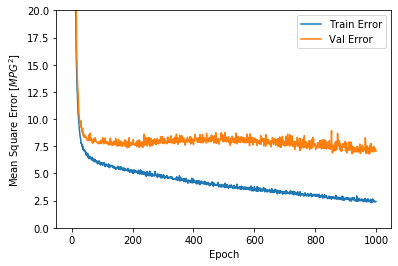

In [24]:
def plot_history(history: tf.keras.callbacks.History) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

That's not good. It looks like our validation error stopped improving after ~200 epochs and actually got _worse_ around 500-600 epochs. This seems like textbook [overfitting](https://en.wikipedia.org/wiki/Overfitting).

In [29]:
%%HTML
<iframe src="https://en.wikipedia.org/wiki/Overfitting" width="900" height="500"></iframe>


How about if we predict on our example batch again?

In [25]:
model.predict(example_batch)

array([[26.87983 ],
       [23.134052],
       [12.875172],
       [37.10966 ],
       [35.73888 ],
       [19.928654],
       [38.01875 ],
       [30.57543 ],
       [20.586237],
       [21.513508]], dtype=float32)

And are those predictions stable/deterministic?

In [26]:
model.predict(example_batch)

array([[26.87983 ],
       [23.134052],
       [12.875172],
       [37.10966 ],
       [35.73888 ],
       [19.928654],
       [38.01875 ],
       [30.57543 ],
       [20.586237],
       [21.513508]], dtype=float32)

And how does that compare to the completely untrained model?

In [27]:
model2.predict(example_batch)

array([[-0.2932623 ],
       [-0.07601981],
       [-0.38309133],
       [-0.2754855 ],
       [-0.17604262],
       [-0.02785384],
       [-0.17826444],
       [-0.0513538 ],
       [-0.02715447],
       [-0.0671993 ]], dtype=float32)

How about if we were to train that network? Would we get the same results for the same input?

In [28]:
model2.fit(
    normed_train_data, 
    train_labels,
    epochs=EPOCHS, 
    validation_split = 0.2, 
    verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [29]:
list(zip(model.predict(example_batch), model2.predict(example_batch)))

[(array([26.87983], dtype=float32), array([27.628386], dtype=float32)),
 (array([23.134052], dtype=float32), array([23.001629], dtype=float32)),
 (array([12.875172], dtype=float32), array([12.779822], dtype=float32)),
 (array([37.10966], dtype=float32), array([37.14297], dtype=float32)),
 (array([35.73888], dtype=float32), array([35.638794], dtype=float32)),
 (array([19.928654], dtype=float32), array([19.49616], dtype=float32)),
 (array([38.01875], dtype=float32), array([37.821285], dtype=float32)),
 (array([30.57543], dtype=float32), array([30.162401], dtype=float32)),
 (array([20.586237], dtype=float32), array([20.233015], dtype=float32)),
 (array([21.513508], dtype=float32), array([20.641964], dtype=float32))]

What are the actual differences in prediction value?

In [30]:
model.predict(example_batch) - model2.predict(example_batch)

array([[-0.74855614],
       [ 0.1324234 ],
       [ 0.09534931],
       [-0.03330994],
       [ 0.10008621],
       [ 0.4324932 ],
       [ 0.19746399],
       [ 0.41302872],
       [ 0.3532219 ],
       [ 0.8715439 ]], dtype=float32)

## Early stopping

We can prevent overfitting to some degree via _early stopping_, wherein we monitor improvement in some metric and end the training routine after some tolerance of no improvement. `tf.keras` provides this for us as a built-in callback object.

In [36]:
%%HTML
<iframe src="https://en.wikipedia.org/wiki/Early_stopping" width="900" height="500"></iframe>


Let's give it a shot on our model.


......................................................

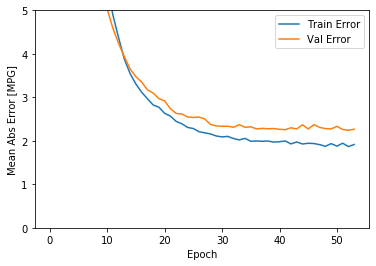

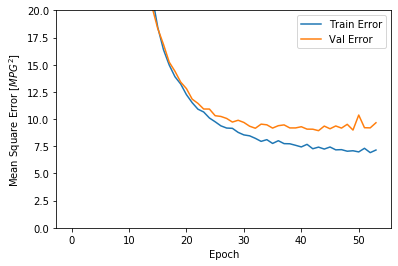

In [31]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# In this example, we'll monitor the validation loss for improvement and tolerate 10 epochs of stagnation.

history = model.fit(
    normed_train_data, 
    train_labels, 
    epochs=EPOCHS,
    validation_split = 0.2, 
    verbose=0, 
    callbacks=[early_stop, PrintDot()]
)

plot_history(history)

We got through less than 100 epochs before pulling the plug due to no improvement in the validation loss function!

Let's try again on a second model.


............................................

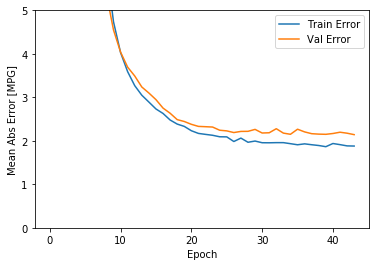

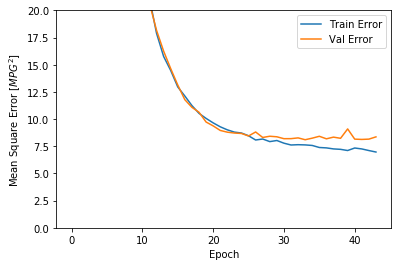

In [34]:
model2 = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history2 = model2.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history2)

In [35]:
len(history.epoch), len(history2.epoch)

(54, 44)

Ok, so training the same model different times using the same routine gives us different numbers of required epochs before training terminates.

Let's check out the model predictions between the two models.

In [36]:
model.predict(example_batch) - model2.predict(example_batch)

array([[ 0.99724007],
       [ 0.54335594],
       [ 0.14667225],
       [ 0.26123428],
       [ 0.82056046],
       [ 0.5086918 ],
       [ 1.0368996 ],
       [ 0.828207  ],
       [ 0.28744507],
       [-0.26097298]], dtype=float32)

Still a difference, although certainly less than before.

In [37]:
loss1, mae1, mse1 = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae1))

78/78 - 0s - loss: 6.6514 - mae: 2.0151 - mse: 6.6514
Testing set Mean Abs Error:  2.02 MPG


In [38]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae2))

78/78 - 0s - loss: 5.8693 - mae: 1.9031 - mse: 5.8693
Testing set Mean Abs Error:  1.90 MPG


In [39]:
(mae1 - mae2) / mae1

0.055576373

Let's plot our predictions vs the true values to see if we're off in any consistent fashion.

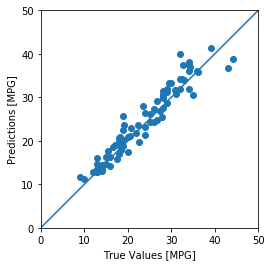

In [40]:
test_predictions1 = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

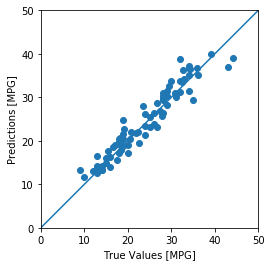

In [41]:
test_predictions2 = model2.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions2)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

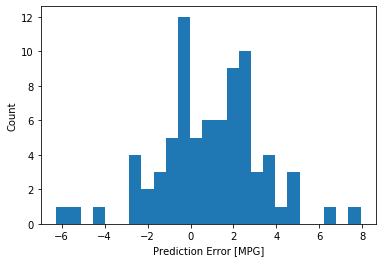

In [42]:
error1 = test_predictions1 - test_labels
plt.hist(error1, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

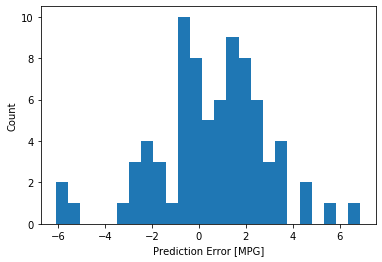

In [43]:
error2 = test_predictions2 - test_labels
plt.hist(error2, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It looks like we're off by a somewhat normal fashion in each of the error sets, but each prediction set is limited by its sample size. What if we were to combine the two error sets together?

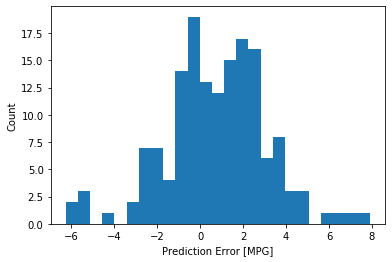

In [44]:
combined_errors = pd.concat([error1, error2])
plt.hist(combined_errors, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

The Central Limit Theorem at work!

In [49]:
%%HTML
<iframe src="https://en.wikipedia.org/wiki/Central_limit_theorem" width="900" height="800"></iframe>


### Takeaways:
- Neural networks are subject to _uncertainty_ in their weights due to the random nature of their initialization and the selection of training/validation data
- This can lead to different weight selections in repeated applications of the same training routine.
- This property is present, even when tricks like Early Stopping are used to control for overfitting.

## Adding dropout

In [47]:
def build_dropout_model() -> tf.keras.Model:
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

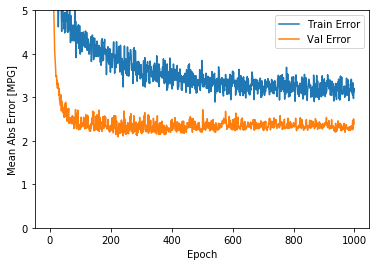

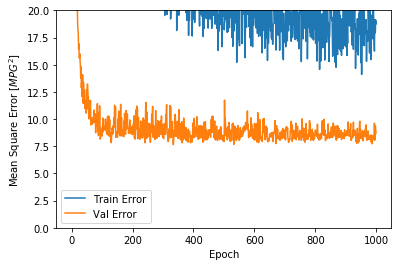

In [48]:
dropout_model = build_dropout_model()

history_dropout = dropout_model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[PrintDot()])

plot_history(history_dropout)

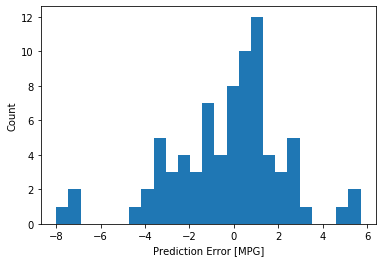

In [52]:
test_dropout_predictions = dropout_model.predict(normed_test_data).flatten()

dropout_error = test_dropout_predictions - test_labels
plt.hist(dropout_error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")